In [1]:
import os
from os import environ
import sys
import io
from os.path import expanduser
sys.path.append("../model/robosat_pink/")


from importlib import import_module
import pkgutil

import pandas as pd

import boto3
import s3fs

import ipywidgets as widgets

from re import match 

import sklearn
from tqdm import tqdm, tqdm_notebook

from numpy.random import randint
import numpy as np

import robosat_pink.losses
import robosat_pink.models
from robosat_pink.datasets import MultiSlippyMapTilesConcatenation
from robosat_pink.tools.train import get_dataset_loaders
from robosat_pink.config import load_config
from robosat_pink.logs import Logs
from robosat_pink.metrics import Metrics

import skimage

import torch
import torch.backends.cudnn
from torch.optim import Adam
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
%matplotlib inline

# Large-Scale Performance Stats

## Pick Trained Model to Test

In [2]:
fs = s3fs.S3FileSystem(session = boto3.Session(profile_name='esip'))
models = fs.walk("planet-snowcover-models")
ans = widgets.Select(options=models, layout = {'width': "500px"}, rows = 20)
ans

Select(layout=Layout(width='500px'), options=('planet-snowcover-models/checkpoint-16-may-all.pth', 'planet-sno…

In [3]:
trainedModel = "s3://" + ans.value
print(trainedModel)

s3://planet-snowcover-models/checkpoint-16-may-all.pth


Load trained model.

In [4]:
# trainedModel = "s3://planet-snowcover-models/checkpoint-190319-20:47:57"
# trainedModel = "s3://planet-snowcover-models/checkpoint-16-may-all.pth"

S3_CHECKPOINT = False
if trainedModel.startswith("s3://"):
    S3_CHECKPOINT = True
    # load from s3 
    trainedModel = trainedModel[5:]
    sess = boto3.Session(profile_name='esip')
    fs = s3fs.S3FileSystem(session=sess)
    s3ckpt = s3fs.S3File(fs, trainedModel, 'rb')
    


## Pick Dataset Configuration

In [5]:
modelConfig = '../s3-train.toml'


## Build Network

In [6]:
config = load_config(modelConfig)

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")


num_classes = len(config["classes"])
num_channels = 0
for channel in config["channels"]:
    num_channels += len(channel["bands"])
pretrained = config["model"]["pretrained"]
encoder = config["model"]["encoder"]

models = [name for _, name, _ in pkgutil.iter_modules([os.path.dirname(robosat_pink.models.__file__)])]
if config["model"]["name"] not in [model for model in models]:
    sys.exit("Unknown model, thoses available are {}".format([model for model in models]))

model_module = import_module("robosat_pink.models.{}".format(config["model"]["name"]))
net = getattr(model_module, "{}".format(config["model"]["name"].title()))(
    num_classes=num_classes, num_channels=num_channels, encoder=encoder, pretrained=pretrained
).to(device)

net = torch.nn.DataParallel(net)
optimizer = Adam(net.parameters(), lr=config["model"]["lr"], weight_decay=config["model"]["decay"])


## Load Images

In [7]:
fs = s3fs.S3FileSystem(session = boto3.Session(profile_name = config['dataset']['aws_profile']))

imagery_searchpath = config['dataset']['image_bucket']  + '/' +  config['dataset']['imagery_directory_regex']
print("Searching for imagery...({})".format(imagery_searchpath))
imagery_candidates = fs.ls(config['dataset']['image_bucket'])
print("candidates:")
print(imagery_candidates)
imagery_locs = [c for c in imagery_candidates if match(imagery_searchpath, c)]
print("result:")
print(imagery_locs)

mask_searchpath = config['dataset']['mask_bucket'] + '/' +  config['dataset']['mask_directory_regex']
print("Searching for mask...({})".format(mask_searchpath))
mask_candidates = fs.ls(config['dataset']['mask_bucket'])
print("candidates:")
print(mask_candidates)
mask_locs = [c for c in mask_candidates if match(mask_searchpath, c)]
print("result:")
print(mask_locs)

assert(len(mask_locs) > 0 and len(imagery_locs) > 0)

print("Merging tilesets...")

allTiles = MultiSlippyMapTilesConcatenation(imagery_locs, mask_locs, aws_profile = config['dataset']['aws_profile'])


Searching for imagery...(planet-snowcover-imagery/(.*)_AnalyticMS_SR_clip_tiled)
candidates:
['planet-snowcover-imagery/20180423_180737_1009_3B_AnalyticMS_DN_udm_clip.tif', 'planet-snowcover-imagery/20180601_181447_0f32_3B_AnalyticMS_DN_udm_clip.tif', 'planet-snowcover-imagery/20180601_181447_0f32_3B_AnalyticMS_SR_clip.tif', 'planet-snowcover-imagery/20180601_181447_0f32_3B_AnalyticMS_metadata_clip.xml', 'planet-snowcover-imagery/20180601_181447_0f32_metadata.json', 'planet-snowcover-imagery/20180601_181448_0f32_3B_AnalyticMS_DN_udm_clip.tif', 'planet-snowcover-imagery/20180601_181448_0f32_3B_AnalyticMS_SR_clip.tif', 'planet-snowcover-imagery/20180601_181448_0f32_3B_AnalyticMS_metadata_clip.xml', 'planet-snowcover-imagery/20180601_181448_0f32_metadata.json', 'planet-snowcover-imagery/20180601_181449_0f32_3B_AnalyticMS_DN_udm_clip.tif', 'planet-snowcover-imagery/20180601_181449_0f32_3B_AnalyticMS_SR_clip_scaled.tif', 'planet-snowcover-imagery/20180601_181449_0f32_3B_AnalyticMS_metadata_

Make DataLoader:


In [8]:
loader = DataLoader(allTiles,
                    batch_size = 7 , 
                    shuffle = True,
                    num_workers = 1)

## Evaluate Batches

In [9]:
batchStats = []

net.eval()

for images, masks, _tiles in tqdm(loader, desc="Predict", unit="batch", ascii=True):

    with torch.no_grad():
        raw = net(images)

    for raw_prob, mask in zip(raw, masks):
        prob = raw_prob > 0 
        print(np.mean(prob.flatten().cpu().numpy()))
        stats = sklearn.metrics.precision_recall_fscore_support(
                    np.round(mask.flatten().cpu().numpy()),
                    prob.flatten().cpu().numpy(), average='binary')
        batchStats.append(stats)
        
        

        


Predict:   0%|          | 0/63 [00:00<?, ?batch/s]

1.0
1.0
1.0
1.0


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
Predict:   2%|1         | 1/63 [00:40<41:27, 40.12s/batch]

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


Predict:   3%|3         | 2/63 [01:17<39:31, 38.88s/batch]

1.0
1.0
1.0
1.0
1.0
1.0


Predict:   5%|4         | 3/63 [01:55<38:30, 38.51s/batch]

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


Predict:   6%|6         | 4/63 [02:33<37:47, 38.43s/batch]

1.0
1.0
1.0
1.0
1.0
1.0
1.0


Predict:   8%|7         | 5/63 [03:11<36:57, 38.24s/batch]

1.0
1.0
1.0
1.0
1.0
1.0
1.0


Predict:  10%|9         | 6/63 [03:49<36:18, 38.22s/batch]

1.0
1.0
1.0
1.0
1.0
1.0
1.0


Predict:  11%|#1        | 7/63 [04:26<35:33, 38.11s/batch]

1.0
1.0
1.0
1.0
1.0
1.0
1.0


Predict:  13%|#2        | 8/63 [05:04<34:52, 38.05s/batch]

1.0
1.0
1.0
1.0
1.0
1.0
1.0


Predict:  14%|#4        | 9/63 [05:43<34:18, 38.13s/batch]

1.0
1.0
1.0
1.0
1.0
1.0
1.0


Predict:  16%|#5        | 10/63 [06:20<33:36, 38.05s/batch]

1.0
1.0
1.0
1.0
1.0
1.0
1.0


Predict:  17%|#7        | 11/63 [06:57<32:55, 37.99s/batch]

1.0
1.0
1.0
1.0
1.0
1.0


Predict:  19%|#9        | 12/63 [07:35<32:15, 37.95s/batch]

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


Predict:  21%|##        | 13/63 [08:12<31:35, 37.92s/batch]

1.0
1.0
1.0
1.0
1.0
1.0
1.0

Predict:  22%|##2       | 14/63 [08:50<30:55, 37.88s/batch]


1.0
1.0
1.0
1.0
1.0
1.0
1.0


Predict:  24%|##3       | 15/63 [09:27<30:16, 37.85s/batch]

1.0
1.0
1.0
1.0
1.0
1.0


Predict:  25%|##5       | 16/63 [10:05<29:37, 37.82s/batch]

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


Predict:  27%|##6       | 17/63 [10:42<28:57, 37.78s/batch]

1.0
1.0
1.0
1.0
1.0
1.0
1.0

Predict:  29%|##8       | 18/63 [11:19<28:19, 37.76s/batch]


1.0
1.0
1.0
1.0
1.0
1.0
1.0


Predict:  30%|###       | 19/63 [11:57<27:40, 37.74s/batch]

1.0
1.0
1.0
1.0
1.0
1.0


Predict:  32%|###1      | 20/63 [12:34<27:02, 37.74s/batch]

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


Predict:  33%|###3      | 21/63 [13:12<26:24, 37.73s/batch]

1.0
1.0
1.0
1.0
1.0
1.0


Predict:  35%|###4      | 22/63 [13:49<25:46, 37.72s/batch]

1.0
1.0
1.0
1.0
1.0
1.0
1.0


Predict:  37%|###6      | 23/63 [14:27<25:08, 37.70s/batch]

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


Predict:  38%|###8      | 24/63 [15:04<24:30, 37.69s/batch]

1.0
1.0
1.0
1.0
1.0
1.0
1.0


Predict:  40%|###9      | 25/63 [15:42<23:52, 37.69s/batch]

1.0
1.0
1.0
1.0
1.0
1.0
1.0


Predict:  41%|####1     | 26/63 [16:19<23:14, 37.68s/batch]

1.0
1.0
1.0
1.0
1.0
1.0
1.0


Predict:  43%|####2     | 27/63 [16:57<22:36, 37.67s/batch]

1.0
1.0
1.0
1.0
1.0
1.0
1.0


Predict:  44%|####4     | 28/63 [17:34<21:58, 37.67s/batch]

1.0
1.0
1.0
1.0
1.0
1.0
1.0


Predict:  46%|####6     | 29/63 [18:12<21:20, 37.66s/batch]

1.0
1.0
1.0
1.0
1.0
1.0
1.0


Predict:  48%|####7     | 30/63 [18:49<20:42, 37.66s/batch]

1.0
1.0
1.0
1.0
1.0
1.0
1.0


Predict:  49%|####9     | 31/63 [19:27<20:04, 37.65s/batch]

1.0
1.0
1.0
1.0
1.0
1.0
1.0


Predict:  51%|#####     | 32/63 [20:04<19:27, 37.65s/batch]

1.0
1.0
1.0
1.0
1.0
1.0
1.0


Predict:  52%|#####2    | 33/63 [20:43<18:50, 37.68s/batch]

1.0
1.0
1.0
1.0
1.0
1.0
1.0


Predict:  54%|#####3    | 34/63 [21:20<18:12, 37.67s/batch]

1.0
1.0
1.0
1.0
1.0
1.0
1.0


Predict:  56%|#####5    | 35/63 [21:58<17:34, 37.66s/batch]

1.0
1.0
1.0
1.0
1.0
1.0
1.0


Predict:  57%|#####7    | 36/63 [22:35<16:56, 37.66s/batch]

1.0
1.0
1.0
1.0
1.0
1.0
1.0


Predict:  59%|#####8    | 37/63 [23:13<16:18, 37.65s/batch]

1.0
1.0
1.0
1.0
1.0
1.0
1.0


Predict:  60%|######    | 38/63 [23:50<15:41, 37.64s/batch]

1.0
1.0
1.0
1.0
1.0
1.0
1.0


Predict:  62%|######1   | 39/63 [24:27<15:03, 37.64s/batch]

1.0
1.0
1.0
1.0
1.0
1.0
1.0


Predict:  63%|######3   | 40/63 [25:05<14:25, 37.64s/batch]

1.0
1.0
1.0
1.0
1.0
1.0
1.0


Predict:  65%|######5   | 41/63 [25:43<13:47, 37.63s/batch]

1.0
1.0
1.0
1.0
1.0
1.0
1.0


Predict:  67%|######6   | 42/63 [26:20<13:10, 37.63s/batch]

1.0
1.0
1.0
1.0
1.0
1.0
1.0


Predict:  68%|######8   | 43/63 [26:57<12:32, 37.62s/batch]

1.0
1.0
1.0
1.0
1.0
1.0
1.0


Predict:  70%|######9   | 44/63 [27:35<11:54, 37.62s/batch]

1.0
1.0
1.0
1.0
1.0
1.0
1.0


Predict:  71%|#######1  | 45/63 [28:12<11:17, 37.62s/batch]

1.0
1.0
1.0
1.0
1.0
1.0
1.0


Predict:  73%|#######3  | 46/63 [28:50<10:39, 37.62s/batch]

1.0
1.0
1.0
1.0
1.0
1.0
1.0


Predict:  75%|#######4  | 47/63 [29:28<10:01, 37.62s/batch]

1.0
1.0
1.0
1.0
1.0
1.0
1.0


Predict:  76%|#######6  | 48/63 [30:05<09:24, 37.62s/batch]

1.0
1.0
1.0
1.0
1.0
1.0
1.0


Predict:  78%|#######7  | 49/63 [30:43<08:46, 37.61s/batch]

1.0
1.0
1.0
1.0
1.0
1.0
1.0


Predict:  79%|#######9  | 50/63 [31:20<08:08, 37.61s/batch]

1.0
1.0
1.0
1.0
1.0
1.0
1.0


Predict:  81%|########  | 51/63 [31:58<07:31, 37.61s/batch]

1.0
1.0
1.0
1.0
1.0
1.0
1.0


Predict:  83%|########2 | 52/63 [32:35<06:53, 37.61s/batch]

1.0
1.0
1.0
1.0
1.0
1.0
1.0

Predict:  84%|########4 | 53/63 [33:13<06:16, 37.60s/batch]


1.0
1.0
1.0
1.0
1.0
1.0
1.0


Predict:  86%|########5 | 54/63 [33:50<05:38, 37.61s/batch]

1.0
1.0
1.0
1.0
1.0
1.0
1.0


Predict:  87%|########7 | 55/63 [34:28<05:00, 37.60s/batch]

1.0
1.0
1.0
1.0
1.0
1.0
1.0


Predict:  89%|########8 | 56/63 [35:05<04:23, 37.60s/batch]

1.0
1.0
1.0
1.0
1.0
1.0
1.0


Predict:  90%|######### | 57/63 [35:43<03:45, 37.61s/batch]

1.0
1.0
1.0
1.0
1.0
1.0
1.0


Predict:  92%|#########2| 58/63 [36:21<03:08, 37.61s/batch]

1.0
1.0
1.0
1.0
1.0
1.0


Predict:  94%|#########3| 59/63 [36:58<02:30, 37.61s/batch]

1.0
1.0
1.0
1.0
1.0
1.0
1.0


Predict:  95%|#########5| 60/63 [37:36<01:52, 37.61s/batch]

1.0
1.0
1.0
1.0
1.0
1.0
1.0


Predict:  97%|#########6| 61/63 [38:14<01:15, 37.61s/batch]

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


Predict:  98%|#########8| 62/63 [38:51<00:37, 37.60s/batch]

1.0
1.0
1.0
1.0
1.0
1.0
1.0


Predict: 100%|##########| 63/63 [39:31<00:00, 37.64s/batch]

1.0
1.0


In [15]:
aggStats = np.array([s[:3] for s in batchStats if s[0] != 0.0])

In [16]:
aggStats

array([[5.45867920e-01, 1.00000000e+00, 7.06228408e-01],
       [1.07387543e-01, 1.00000000e+00, 1.93947536e-01],
       [5.17799377e-01, 1.00000000e+00, 6.82302793e-01],
       [7.70385742e-01, 1.00000000e+00, 8.70302696e-01],
       [2.62870789e-02, 1.00000000e+00, 5.12275355e-02],
       [4.95910645e-04, 1.00000000e+00, 9.91329678e-04],
       [1.11984253e-01, 1.00000000e+00, 2.01413379e-01],
       [1.32705688e-01, 1.00000000e+00, 2.34316274e-01],
       [1.36680603e-02, 1.00000000e+00, 2.69675268e-02],
       [1.47090912e-01, 1.00000000e+00, 2.56459031e-01],
       [3.65962982e-01, 1.00000000e+00, 5.35831479e-01],
       [5.42068481e-02, 1.00000000e+00, 1.02839112e-01],
       [2.55943298e-01, 1.00000000e+00, 4.07571422e-01],
       [2.05230713e-03, 1.00000000e+00, 4.09620758e-03],
       [9.53674316e-05, 1.00000000e+00, 1.90716675e-04],
       [4.37953949e-01, 1.00000000e+00, 6.09134874e-01],
       [3.42021942e-01, 1.00000000e+00, 5.09711401e-01],
       [2.71453857e-02, 1.00000

In [11]:
aggStats.Precision.mean(), aggStats.Recall.mean(), aggStats.F1.mean()

AttributeError: 'numpy.ndarray' object has no attribute 'Precision'

In [12]:
limit = 8
images, masks, tiles = [], [], []
idxs = np.random.randint(0, len(allTiles), size=limit)
for i in idxs:
    i, m, t = allTiles[i]
    print(t)
    images.append(i)
    masks.append(m)
    tiles.append(t)

    
imageTensor = torch.from_numpy(np.stack(images))

2e85f6b7a36d870a74566dff9cb3bc75-5554-12685-15
6c3fdc04b3ef10f50c192d86ebb8f144-5547-12702-15
898c3daa4112e8a7efe1ca89a833dec7-5506-12700-15
2e85f6b7a36d870a74566dff9cb3bc75-5551-12687-15
2e85f6b7a36d870a74566dff9cb3bc75-5558-12688-15
6db35152a3edab340e601ebff65f3e96-5545-12685-15
6db35152a3edab340e601ebff65f3e96-5553-12683-15
6db35152a3edab340e601ebff65f3e96-5548-12685-15


In [13]:
with torch.no_grad():
    raw = net(imageTensor)

for raw_prob, mask in zip(raw, masks):
    prob = raw_prob > 0 
    stats = sklearn.metrics.precision_recall_fscore_support(
                np.round(mask.flatten().cpu().numpy()),
                prob.flatten().cpu().numpy(), average='binary')



/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


In [13]:
print(raw)

tensor([[[[-0.1348, -0.1303, -0.1343,  ..., -0.1366, -0.1376, -0.1401],
          [-0.1399, -0.1408, -0.1384,  ..., -0.1372, -0.1411, -0.1418],
          [-0.1404, -0.1369, -0.1358,  ..., -0.1416, -0.1408, -0.1392],
          ...,
          [-0.1409, -0.1427, -0.1416,  ..., -0.1295, -0.1516, -0.1624],
          [-0.1386, -0.1432, -0.1432,  ..., -0.1538, -0.1509, -0.1569],
          [-0.1352, -0.1373, -0.1326,  ..., -0.1287, -0.1270, -0.1249]]],


        [[[-0.1330, -0.1248, -0.1290,  ..., -0.1414, -0.1388, -0.1401],
          [-0.1390, -0.1357, -0.1421,  ..., -0.1407, -0.1426, -0.1433],
          [-0.1451, -0.1423, -0.1413,  ..., -0.1464, -0.1448, -0.1416],
          ...,
          [-0.1381, -0.1388, -0.1408,  ..., -0.1400, -0.1412, -0.1424],
          [-0.1386, -0.1428, -0.1428,  ..., -0.1447, -0.1397, -0.1423],
          [-0.1353, -0.1375, -0.1329,  ..., -0.1365, -0.1348, -0.1346]]],


        [[[-0.1342, -0.1293, -0.1337,  ..., -0.1429, -0.1402, -0.1384],
          [-0.1413, -0.140

In [14]:
def plot3(image, mask, pred, tile, ax = None):
#     fig.suptitle(tile)
    ax[0].imshow(image)
    ax[0].set_title(tile)
    ax[1].imshow(mask)
    ax[1].set_title("mask")
    ax[2].imshow(pred, cmap='cividis', vmin = 0.2, vmax = 1)
    ax[2].set_title('prediction')
#     diff = ax[3].imshow((pred > 0) - mask, cmap='seismic')
    mets = sklearn.metrics.precision_recall_fscore_support(np.round(mask.flatten()), 
                                                          (pred > 0).flatten().astype(int), average='binary')
    ax[2].set_title(mets)
        
    print(mets)
    return(mets)

#     plt.colorbar(diff, ax = ax[3])
    # NDSI = 1-4 / 1 + 4
#    plt.colorbar(pred, ax  = ax[2], orientation='horizontal')


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float32 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to float32
  .format(dtypeobj_in, dtypeobj_out))


TypeError: list indices must be integers or slices, not tuple

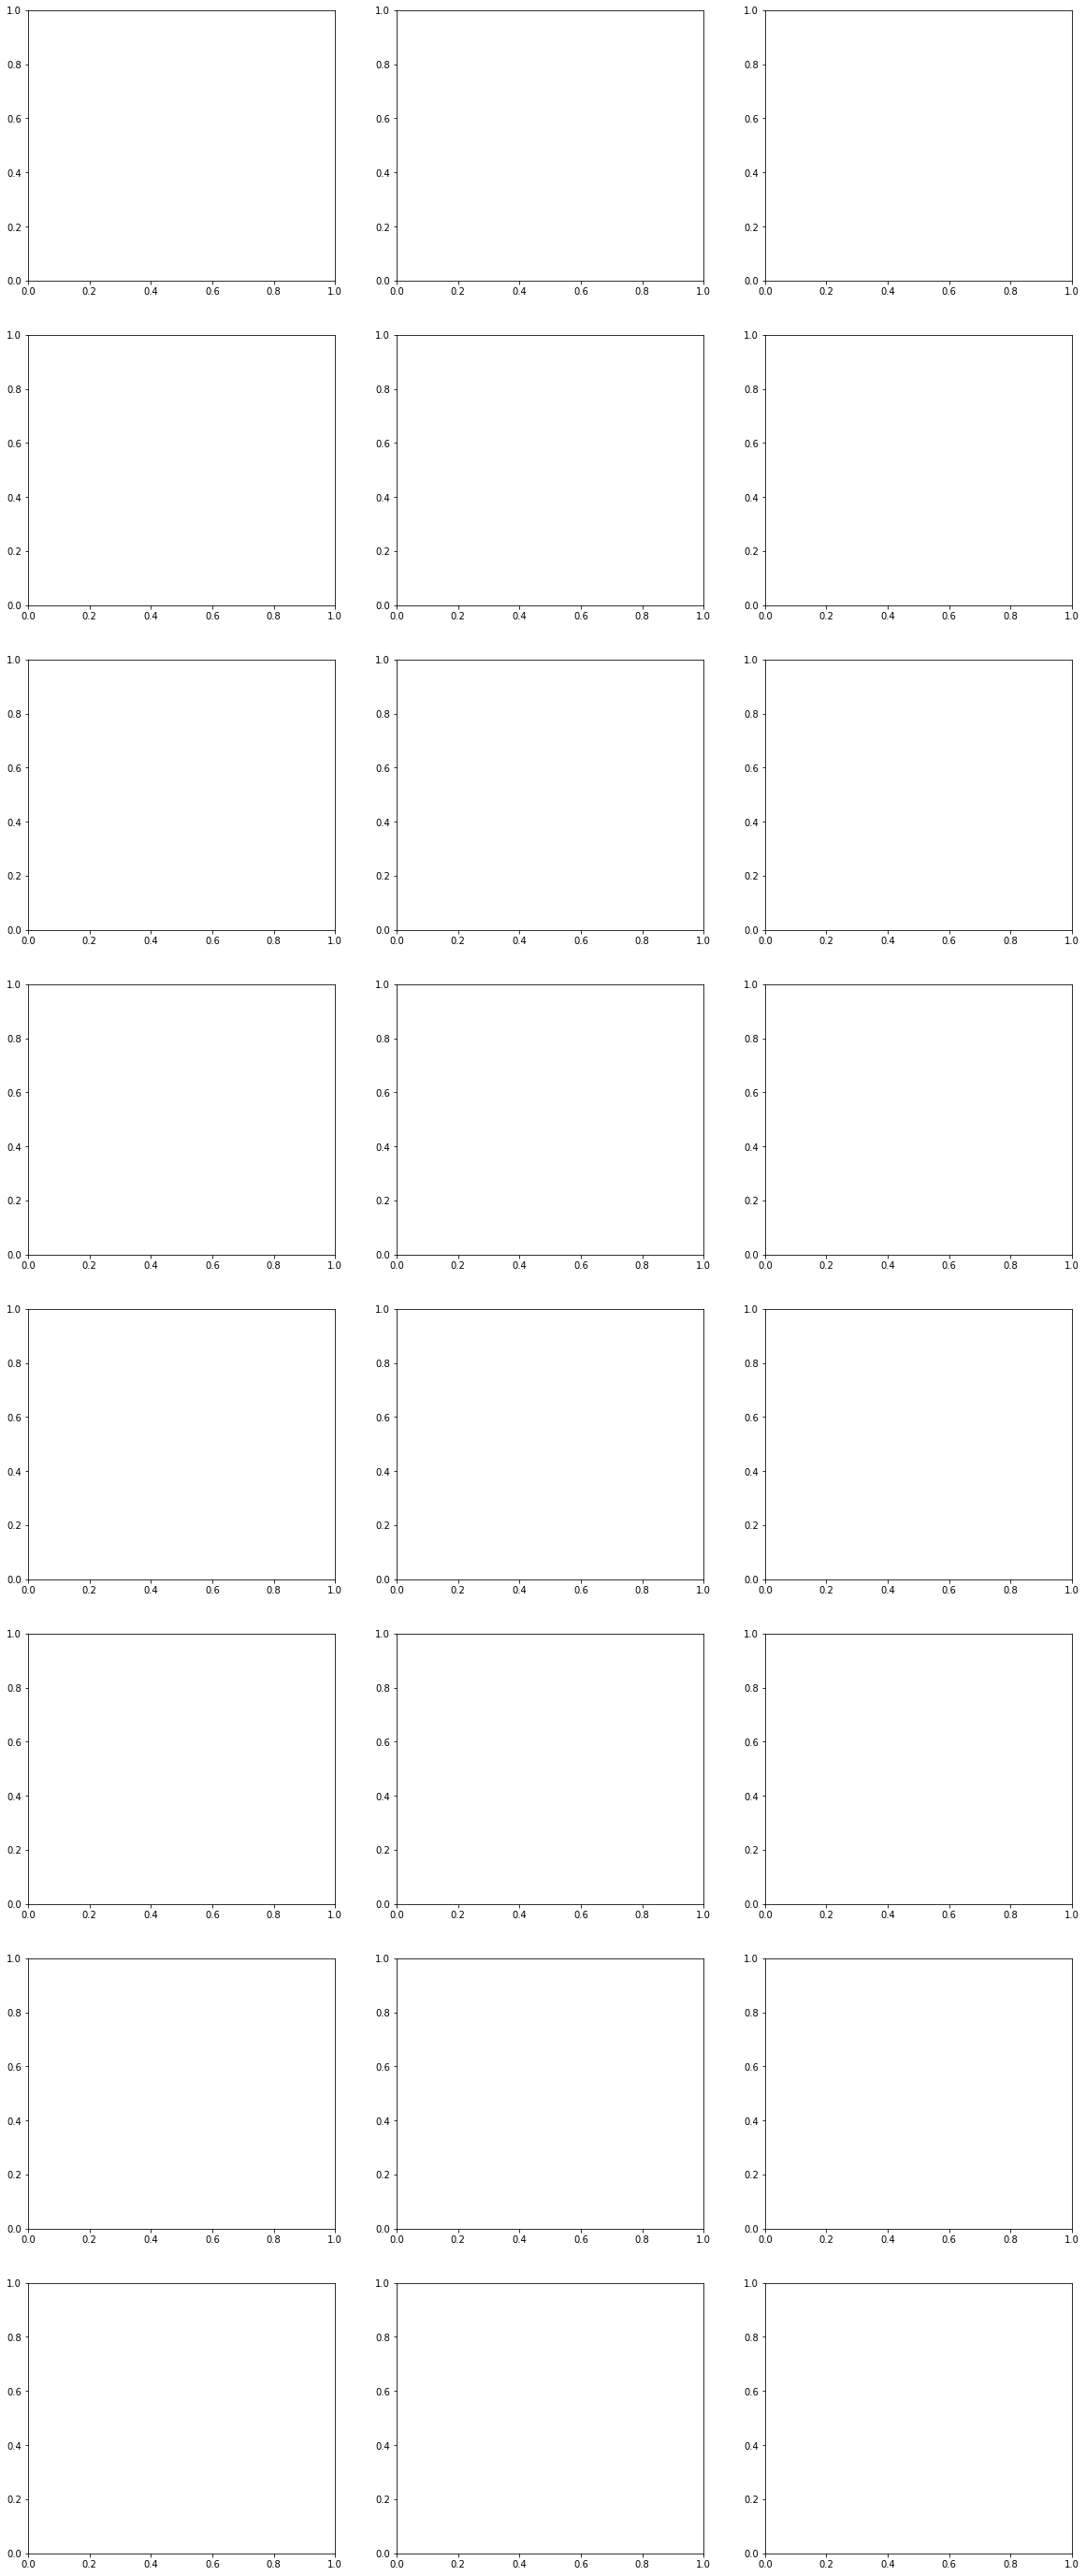

In [15]:
fig, ax = plt.subplots(raw.shape[0], 3, figsize=(20, 50))
mets = []
for image in range(raw.shape[0]):
    imageTensor = imageTensor.cpu()
    raw = raw.cpu()
    rgb = np.moveaxis(imageTensor[image, [2, 1, 0], :, :].numpy(), 0, 2)
    rgb = skimage.exposure.rescale_intensity(skimage.exposure.equalize_adapthist(rgb), in_range = (0, .62))
    met = plot3(rgb, masks[image, :, :],  (raw[image]).cpu().numpy().squeeze()  , tiles[image], ax = ax[image])
    if met[0] != 0:
        mets.append(met)
#    plot3(s[0][image, 3, :, :], s[1][image, :, :],  torch.nn.functional.softmax(raw[image].squeeze(), dim=0).data.cpu().numpy())
fig.suptitle(np.mean(np.array(mets)[:, :3], axis=1))


plt.savefig("testout.png")

In [18]:
imageTensor[0]

tensor([[[0.0259, 0.0267, 0.0280,  ..., 0.0416, 0.0428, 0.0439],
         [0.0255, 0.0263, 0.0277,  ..., 0.0436, 0.0447, 0.0457],
         [0.0254, 0.0260, 0.0274,  ..., 0.0462, 0.0472, 0.0480],
         ...,
         [0.0374, 0.0342, 0.0302,  ..., 0.3643, 0.3174, 0.2828],
         [0.0347, 0.0326, 0.0298,  ..., 0.3798, 0.3426, 0.3152],
         [0.0325, 0.0312, 0.0295,  ..., 0.3905, 0.3602, 0.3378]],

        [[0.0380, 0.0381, 0.0386,  ..., 0.0546, 0.0546, 0.0547],
         [0.0377, 0.0380, 0.0388,  ..., 0.0562, 0.0560, 0.0561],
         [0.0376, 0.0381, 0.0392,  ..., 0.0582, 0.0580, 0.0579],
         ...,
         [0.0455, 0.0428, 0.0393,  ..., 0.3721, 0.3291, 0.2970],
         [0.0430, 0.0411, 0.0387,  ..., 0.3872, 0.3527, 0.3269],
         [0.0410, 0.0398, 0.0382,  ..., 0.3975, 0.3691, 0.3478]],

        [[0.0436, 0.0441, 0.0452,  ..., 0.0655, 0.0655, 0.0657],
         [0.0431, 0.0438, 0.0452,  ..., 0.0676, 0.0677, 0.0679],
         [0.0427, 0.0436, 0.0453,  ..., 0.0705, 0.0707, 0.

In [26]:
(raw[50
    ] > 0).any()


IndexError: index 50 is out of bounds for dimension 0 with size 8